In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import os
import itertools

from multiprocessing import Pool

In [2]:
%run config.py
%run shared.py

In [3]:
valid = pd.read_pickle(PATH_VALID_DEVICES, compression='gzip')

# Notification counts

**RQ:** How many notifications are in the notification drawer?

## 1. Empty

In [4]:
all_snapshots = valid.Zeros.apply(len).sum()
print('Number of snapshots:\n%s' % all_snapshots)

Number of snapshots:
8830112


In [5]:
snapshots_with_no_active_notifications = valid.Zeros.apply(lambda x: x.count(0)).sum()
print('Number of snapshots with no active notifications:\n%s' % snapshots_with_no_active_notifications)

Number of snapshots with no active notifications:
1813104


In [6]:
print('Percentage of snapshots with no active notifications:')
print('%.2f%% [overall]' % (snapshots_with_no_active_notifications / all_snapshots * 100))

Percentage of snapshots with no active notifications:
20.53% [overall]


In [7]:
print('Percentage of snapshots with no active notifications:')
print('%.2f%% [normalized]' % (valid.Zeros.apply(lambda x: x.count(0) / len(x)).mean() * 100))

Percentage of snapshots with no active notifications:
21.96% [normalized]


## 2. Max

In [8]:
print('Maximum number of notifications in a snapshot:')
print(valid.Zeros.apply(max).max())

Maximum number of notifications in a snapshot:
160


## 3. Count - All

In [9]:
def worker_count_all(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    df.Active = df.Active.apply(len)
    return df.Active.sum()

In [10]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_count_all, uuids)

len(lst)

3953

In [11]:
lst

[1195,
 4423,
 4014,
 5813,
 1533,
 58009,
 3202,
 4874,
 1544,
 3672,
 5954,
 1216,
 9595,
 8691,
 1911,
 5294,
 1379,
 13922,
 9078,
 149155,
 8246,
 1441,
 4365,
 7481,
 3851,
 17589,
 8042,
 17571,
 1005,
 1739,
 1395,
 2957,
 2892,
 49628,
 18532,
 13790,
 1982,
 11975,
 16634,
 2625,
 3726,
 2620,
 2431,
 10337,
 1047,
 16307,
 4155,
 876,
 4464,
 3878,
 24191,
 17228,
 7711,
 9384,
 2887,
 6051,
 419,
 10836,
 6886,
 1143,
 5086,
 3894,
 12445,
 4534,
 2785,
 1740,
 7035,
 1746,
 2908,
 1535,
 6422,
 459,
 63789,
 5238,
 11553,
 4802,
 11545,
 6068,
 8334,
 565,
 8152,
 16279,
 8465,
 631,
 9115,
 3197,
 3561,
 3760,
 2776,
 3630,
 19758,
 3900,
 4384,
 2454,
 40375,
 7017,
 5408,
 1614,
 9187,
 18401,
 2105,
 11451,
 2598,
 4693,
 14057,
 1205,
 19388,
 13975,
 20634,
 5936,
 4711,
 22103,
 3096,
 2655,
 1792,
 6228,
 698,
 4743,
 11531,
 16624,
 7856,
 1089,
 1404,
 1819,
 2092,
 402,
 1325,
 12487,
 3290,
 5375,
 7010,
 11197,
 1632,
 16002,
 587,
 3094,
 17707,
 24079,
 2194

In [12]:
pd.Series(lst).describe()

count      3953.000000
mean      10330.467999
std       20903.454967
min         107.000000
25%        2189.000000
50%        4460.000000
75%       10103.000000
max      407340.000000
dtype: float64

In [13]:
print('Total number of notifications in all snapshots:')
print(np.sum(lst))

Total number of notifications in all snapshots:
40836340


## 4. Count - Unique

In [14]:
def get_notification_identifiers(lst):
    result = []
    for n in lst:
        result.append(n['key'] + '@' + str(n['postTime']))
    return result

def worker_count_individual(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    df.Active = df.Active.apply(get_notification_identifiers) 
    result = df.Active.tolist()
    result = list(itertools.chain(*result))
    return len(set(result))

In [15]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_count_individual, uuids)

len(lst)

3953

In [16]:
pd.Series(lst).describe()

count     3953.000000
mean      2764.705287
std       3764.329569
min         65.000000
25%        777.000000
50%       1514.000000
75%       3200.000000
max      55703.000000
dtype: float64

In [17]:
print('Total number of UNIQUE notifications in all snapshots:')
print(np.sum(lst))

Total number of UNIQUE notifications in all snapshots:
10928880


## 5. Mean - All

In [18]:
def worker_count_total(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    df.Active = df.Active.apply(len)
    return pd.DataFrame({
        'UUID': uuid.replace('.pkl', ''),
        'MeanActive': df.Active.mean(),
        'StdActive': df.Active.std(),
        '05PActive': df.Active.quantile(.05),
        '25PActive': df.Active.quantile(.25),
        'MedianActive': df.Active.median(),
        '75PActive': df.Active.quantile(.75),
        '95PActive': df.Active.quantile(.95),
        'MinActive': df.Active.min(),
        'MaxActive': df.Active.max(),
    }, index=[0])

In [19]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_count_total, uuids)

count_total = pd.concat(lst)
count_total = count_total.set_index('UUID')
count_total.tail()

,MeanActive,StdActive,05PActive,25PActive,MedianActive,75PActive,95PActive,MinActive,MaxActive
UUID,,,,,,,,,
device.3948,0.856639,1.143193,0.0,0.0,0.0,2.0,3.0,0,6
device.3949,1.072690,1.497368,0.0,0.0,1.0,2.0,4.0,0,10
device.3950,18.052377,7.364444,7.0,13.0,18.0,22.0,33.0,0,43
device.3951,2.270971,2.369038,0.0,1.0,2.0,3.0,7.0,0,18
device.3952,0.648980,0.714114,0.0,0.0,1.0,1.0,2.0,0,3


In [20]:
count_total.MinActive.min()

0

In [21]:
count_total.MaxActive.max()

160

In [22]:
count_total.MeanActive.describe()

count    3953.000000
mean        4.298167
std         5.859919
min         0.078200
25%         1.512928
50%         2.681094
75%         4.608939
max        70.534506
Name: MeanActive, dtype: float64

In [23]:
count_total.MeanActive \
    .apply(lambda x: x - x % 5) \
    .apply(lambda x: x if x < 10 else '10+') \
    .value_counts(dropna=False, normalize=True) \
    .apply(lambda x: str(np.round(x * 100, 2)) + '%')

0.0    77.64%
5.0    14.87%
10+     7.49%
Name: MeanActive, dtype: object

## 6. Mean - Grouped

In [24]:
def worker_count_grouped(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    df.Active = df.Active.apply(filter_active) # <--- this is the difference compared to 'worker_count_total'
    df.Active = df.Active.apply(len)
    return pd.DataFrame({
        'UUID': uuid.replace('.pkl', ''),
        'MeanActive': df.Active.mean(),
        'StdActive': df.Active.std(),
        '05PActive': df.Active.quantile(.05),
        '25PActive': df.Active.quantile(.25),
        'MedianActive': df.Active.median(),
        '75PActive': df.Active.quantile(.75),
        '95PActive': df.Active.quantile(.95),
        'MinActive': df.Active.min(),
        'MaxActive': df.Active.max(),
    }, index=[0])

In [25]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_count_grouped, uuids)

count_grouped = pd.concat(lst)
count_grouped = count_grouped.set_index('UUID')
count_grouped.tail()

,MeanActive,StdActive,05PActive,25PActive,MedianActive,75PActive,95PActive,MinActive,MaxActive
UUID,,,,,,,,,
device.3948,0.696827,0.921225,0.0,0.0,0.0,1.0,3.0,0,5
device.3949,0.940810,1.237674,0.0,0.0,1.0,1.0,4.0,0,8
device.3950,16.823261,7.002872,7.0,12.0,16.0,20.0,31.0,0,41
device.3951,2.094923,2.132247,0.0,1.0,2.0,3.0,6.0,0,15
device.3952,0.648980,0.714114,0.0,0.0,1.0,1.0,2.0,0,3


In [26]:
count_grouped.MinActive.min()

0

In [27]:
count_grouped.MaxActive.max()

155

In [28]:
count_grouped.MeanActive.describe()

count    3953.000000
mean        3.401013
std         4.588902
min         0.066329
25%         1.251316
50%         2.174066
75%         3.683864
max        61.277391
Name: MeanActive, dtype: float64

In [29]:
count_grouped.MeanActive \
    .apply(lambda x: x - x % 5) \
    .apply(lambda x: x if x < 10 else '10+') \
    .value_counts(dropna=False, normalize=True) \
    .apply(lambda x: str(np.round(x * 100, 2)) + '%')

0.0    84.59%
5.0    10.35%
10+     5.06%
Name: MeanActive, dtype: object

## 7. Boxplot

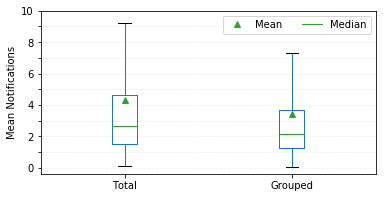

In [30]:
mean_active_combined = pd.concat([
    count_total.MeanActive.rename('Total'),
    count_grouped.MeanActive.rename('Grouped')
], axis=1)

ax = mean_active_combined.boxplot(
    showfliers=False,
    showmeans=True,
    figsize=(6, 3)
)

# Ticks
ax.set_yticks(range(0, 11, 1))
ax.set_yticklabels([x if x % 2 == 0 else '' for x in range(0, 11, 1)])

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.0, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
#ax.set_xlabel('Mean', fontsize=10)
ax.set_ylabel('Mean Notifications', fontsize=10)
ax.tick_params(labelsize=10)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[
    mlines.Line2D([], [], color='#34a333', marker='^', linestyle='None'),
    mlines.Line2D([], [], color='#34a333', linewidth=1)
], labels=[
    'Mean',
    'Median'
], loc='upper right', ncol=2, prop={'size': 10})

plt.savefig('figures/mean_active_boxplot.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/mean_active_boxplot.pdf', bbox_inches='tight', pad_inches=0)

plt.show()